# Vaccine Sentiment Analysis

The aim of this project is to uncover the most discussed topics for anti-vaccine tweets and pro-vaccine tweets. The dataset that we use for this is https://www.kaggle.com/ritesh2000/covid19-vaccine-tweets. To uncover the most discussed topics, a random sample of 1750 tweets was taken from the dataset, and labeled as anti-vaccine, neutral or pro-vaccine. We train a machine learning model on this labeled data to be able to predict the rest of the tweets in the dataset. Subsequently, we apply LDA topic modelling to uncover the most discussed topics.

We do not use any pre-labeled dataset to train the model because most of the datasets that are pre-labeled for sentiment analysis are just labeled by whether someone is expressing positive or negative sentiment. This is not the same as being anti-vaccine, neutral or pro-vaccine. Although some may be positive in the tweet, these people could still tweet something anti-vaccine.

This project was initially a school project for my Master's at Utrecht University, hence, some of the code used in this notebook was adjusted from the code used in this lab manual: https://jveerbeek.gitlab.io/dm-manual/.

### Import Modules for Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

### Import Data for Preprocessing

In [ ]:
df = pd.read_csv('labeled.csv')
df = df[["label", "tweet"]].dropna()
df = df.drop_duplicates('tweet')
pd.set_option("display.max_colwidth", None)
df.head(10)

,label,tweet
0,2,@WokeSide @Jamz129 @no2wind @TheDisproof @BubbasRanch @DigDougFTW @BadgersNo @HuntsonMark @Over400ppm @IBergwiesel @insane_voice @Fiddlers__Green @ReckedRik @NikolausBourba1 @Turfin4u @FeynmanFreaky @AlaMerQld @TQMKA @Narvuntien @jimdtweet @ScottieDrama108 @Bananenrijperij @Dardedar @RoyPentland @Fauntleroy1934 @WeiZhangAtmos @RushhourP @Tangomitteckel @RustyAway @riktheozfrog @StormSignalSA @Homer4K @DanCady @MikeDel21893959 @OutsiderSkyNews @HtServadac @NickAPalmer @RockyRex13 @DawnTJ90 @minton_denis @Chrisdebois1 @cjtjgeol @novakglobal @justinetrudeu @PeterTimes @Pete48068744 @garner_forest @ElectricElecti1 @Niggledom @Osprey0 Are you willing to have a Covid vaccine?
1,2,FDA Delays COVID Vaccine Beyond Election Day; Trump Responds | Conservative Journal ...‚Äùare they really concerned about the safety of the Americans or do they know that an approved vaccine by Election Day benefits Trump politically ? ‚Äú... https://t.co/i51rrdKhAg
2,1,They say it is within decades but the covid vaccine is said to contain nanobots already.
3,2,"@taystan I understand the distrust and how people are associating the flu vaccine to a potential covid vaccine. With that, should blacks take the risk and not get it?"
4,1,Another COVID vaccine using aborted baby cell line pauses trials after participant‚Äôs ‚Äòunexplained illness‚Äô | News | LifeSite https://t.co/IhOcdcKKQd deadly vaccines
5,1,@cjtruth This video is a must watch!!! 22 minutes. Explains EXACTLY what the covid vaccine is and what it does to you scientifically. She is a doctor. The covid vaccine is NOT the same as any previous vaccine and permanently changes your DNA. https://t.co/ML7wDxMpng
6,3,Oxford‚Äôs Covid-19 Vaccine Is the Coronavirus Front-Runner - Bloomberg #COVIDVACCINE https://t.co/GWZz2v2vFD
7,2,ICYMI - James Clapper refuses to testify to Congress in person ‚Äòuntil there‚Äôs a COVID vaccine‚Äô https://t.co/8VoKW7xGfK
8,1,I‚Äôve read on FB CDC is having an emergency meeting to determine if CoVid vaccine will be mandatory. I will not be vaccinated against my will ! Is this true can CDC do this?
9,2,"#CovidVaccine to be available at Rs 225? The Serum Institute of India which has a manufacturing partnership for the vaccine by #OxfordUniversity and Novavax, announced that it will cost $3 for low-and middle-income countries including India. @SumiSukanya https://t.co/QbwPdf0VOh"


We can see that there are some weird combinations of characters in our tweets, such as "‚Äô", that should probably be other characters.

<AxesSubplot:xlabel='label', ylabel='count'>

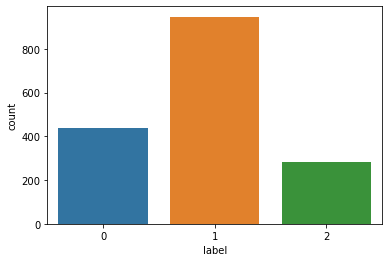

In [ ]:
sns.countplot(x=df["label"])

The target contains class imbalance, we might need to account for this later to see better performance.

### Preprocessing

We now do something about the weird combinations of characters by changing them to what they should be. Also, we reclassify the labels to [0,1,2]. Furthermore, we create the train, test and validation sets from our data. We write the data to csv because we will be doing the training in Google Colab instead of Jupyter.

In [ ]:
df.tweet = df.tweet.str.replace("‚Äô", "\'")
df.tweet = df.tweet.str.replace("‚Äò", "\'")
df.tweet = df.tweet.str.replace("‚Äú", "\"")
df.tweet = df.tweet.str.replace("‚Äù", "\"")

df.label[df.label == 1] = 0
df.label[df.label == 2] = 1
df.label[df.label == 3] = 2

df.to_csv('labeled_processed.csv', index=False)

# Model Training

We do this part of the analysis in Google Colab because it allows us to use their GPU runtime to train the model much faster. Because the sessions in Colab are in an online server, we need to install some packages each time we run our script. 

### Import Modules for Training 

In [1]:
!pip install transformers
!pip install emoji

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import emoji

### Import Data for Training

We also import our data differently in Colab, we mount our google drive and import the data from there.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/My Drive/Vaccine/labeled_processed.csv')

### Preparing the Data for Training

Now that we have the processed data, we create our train, test and validation sets and vectorize them.

In [5]:
X = list(df.tweet.values) 
y = list(df.label.values) 
labels = ['anti-vaccine', 'neutral', 'pro-vaccine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [6]:
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-covid19-base-cased', use_fast=False)

train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128) 
test_encodings = tokenizer(X_test, truncation=True, padding=True,  max_length=128)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128)

train_dataset = tf.data.Dataset.from_tensor_slices((
dict(train_encodings),
    y_train
)).shuffle(1000).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(64)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


### Model Training

To train the model we use a pre-trained transformers model called COVID-Twitter-BERT. This model was pre-trained on many Covid-19 related tweets so this model likely understands much about our dataset containing Covid-19 vaccine tweets, hence, it is our best chance of training a well performing model. We set the class weights to favor the class with the least records to account for the class imbalance. 

In [7]:
model = TFAutoModelForSequenceClassification.from_pretrained('vinai/bertweet-covid19-base-cased', 
                                                             num_labels=len(labels))
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=0, 
                                              mode='min', baseline=None, 
                                              restore_best_weights=True)]

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss)

model.fit(train_dataset, 
          epochs=10,
          callbacks=callbacks, 
          validation_data=val_dataset,
          batch_size=64,
          class_weight={0:1, 1:1, 2:2.5})

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-covid19-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autog

We now load the weights that we saved in an earlier session when we were slightly luckier with the random aspects preparing the data and training the model, we did however use the same hyperparameters as used above.

In [8]:
model.load_weights('/content/drive/My Drive/Data/weights0')

In [9]:
logits = model.predict(test_dataset)
y_preds = np.argmax(logits[0], axis=1)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83        45
           1       0.89      0.91      0.90        98
           2       0.79      0.65      0.71        23

    accuracy                           0.86       166
   macro avg       0.83      0.80      0.81       166
weighted avg       0.85      0.86      0.85       166



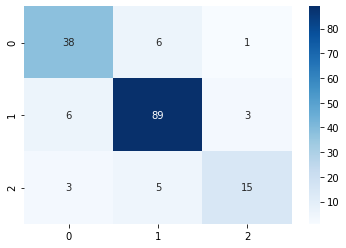

In [10]:
cf_matrix = confusion_matrix(y_test, y_preds)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

As shown in the classification report and confusion matrix, classification performance is not bad and although the scores could be higher, we deem this sufficient for predicting the data. 

### Predicting the Other Records in the Dataset

Now that we have our model, we can predict all other tweets in the dataset as anti-vaccine, neutral or pro-vaccine. We import the full dataset of tweets, create the label column, select only the English tweets and apply the same preprocessing as we did earlier.

In [11]:
df_pred = pd.read_csv('/content/drive/My Drive/Vaccine/vaccine_tweets.csv')
df_pred["label"] = "NaN"
df_pred = df_pred[df_pred.language == 'en']
df_pred.tweet = df_pred.tweet.str.replace("‚Äô", "\'")
df_pred.tweet = df_pred.tweet.str.replace("‚Äò", "\'")
df_pred.tweet = df_pred.tweet.str.replace("‚Äú", "\"")
df_pred.tweet = df_pred.tweet.str.replace("‚Äù", "\"")

We loop over all predictions and add our prediction to the 'label' column.

In [12]:
new_examples = list(df_pred.tweet)
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-covid19-base-cased', use_fast=False)
examples_encodings = tokenizer(new_examples, truncation=True, padding=True, max_length=128)
examples_encodings = tf.data.Dataset.from_tensor_slices((dict(examples_encodings))).batch(64)
pred_logits = model.predict(examples_encodings)

for i, logits in enumerate(pred_logits[0]):
    prediction = np.argmax(logits)
    df_pred["label"][i] = labels[prediction]

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


We write the dataframe to csv so we can go back to using jupyter and import it from disk again.

In [13]:
df_pred.to_csv('/content/drive/My Drive/Vaccine/full_labeled.csv')

## Topic Modelling

Now that we have the full dataset of tweets with predicted labels, we can start modelling the topics in the tweets. First we will import the necessary modules and the data we saved earlier in Google Colab. We also check the distribution of the labels.

### Import Modules for Topic Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import gensim
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
import os
from wordcloud import WordCloud
from PIL import Image

In [2]:
import warnings
warnings.simplefilter('ignore')

### Import Data for Topic Modelling

In [3]:
df = pd.read_csv("full_labeled.csv")
df = df[["label","tweet"]]

In [4]:
df.head()

,label,tweet
0,neutral,@ANI Isn't it the best poll promise ever?? Fre...
1,neutral,Now states shall have wait for thier Vidhan Sa...
2,neutral,@MisseeMonis They said vaccine for all but not...
3,neutral,"BJP really presenting ""free COVID vaccine"" as ..."
4,anti-vaccine,Another dose of daily miserablism from Planet ...


<AxesSubplot:xlabel='label', ylabel='count'>

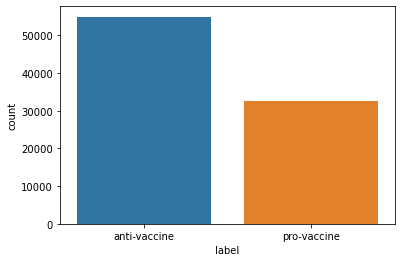

In [5]:
df = df[df.label.isin(['anti-vaccine','pro-vaccine'])]
sns.countplot(x=df.label)

### Text Preprocessing

To preprocess our tweets we use Spacy's lemmatizer to lemmatize the texts and only get the nouns, verbs and adjectives, while removing the stop words and punctuation. Next, we build a dictionary from the lemmatized texts.

In [6]:
nlp = spacy.load("en_core_web_sm")
texts = df.tweet
processed_texts = [text for text in nlp.pipe(texts, disable=["ner","parser"])]
lemmatized_texts = [[token.lemma_ for token in text if token.pos_ == 'NOUN' or token.pos_ == 'ADJ' or
                     token.pos_ == 'VERB' if not token.is_punct and not token.is_stop] for text in processed_texts]
df['lemmatized_texts'] = lemmatized_texts

In [7]:
dictionary = Dictionary(df.lemmatized_texts) 
dictionary.filter_extremes(no_below=3, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in df.lemmatized_texts]

### Topic Model Training

We train the topic model using Mallet. We set the number of topics to 15 and we run the model for 1000 iterations. After, we join the topic distributions with our dataframe to get the topic proportions per document (per tweet in our case) and per topic. We print the first few rows to see if everything worked out.

In [8]:
os.environ['MALLET_HOME'] = r'C:\\Users\Wouter\Tools\mallet-2.0.6' 
mallet_path = r'C:\\Users\Wouter\Tools\mallet-2.0.6\bin\mallet'
num_topics = 15

model = LdaMallet(mallet_path,
                  corpus=corpus,
                  id2word=dictionary,
                  num_topics=num_topics,
                  iterations=1000)

model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)

doc_topics = model.get_document_topics(corpus)
topic_df = pd.DataFrame([[x[1] for x in doc] for doc in doc_topics], 
                        columns=['topic_{}'.format(i) for i in range(num_topics)])
df = df.reset_index().join(topic_df)
df.head()

,index,label,tweet,lemmatized_texts,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,4,anti-vaccine,Another dose of daily miserablism from Planet ...,"[dose, daily, miserablism, sub, pin, hope, cov...",0.095238,0.059524,0.059524,0.127813,0.060725,0.059524,0.059524,0.059524,0.059524,0.059524,0.059524,0.059524,0.061462,0.059524,0.059524
1,7,anti-vaccine,What about non-BJP ruled states? Indians who...,"[non, rule, state, vote, free, covid, vaccine]",0.061728,0.061770,0.061770,0.061728,0.061728,0.061728,0.061834,0.061728,0.061728,0.061728,0.088299,0.080141,0.080241,0.072111,0.061735
2,16,pro-vaccine,If you're pinning your hopes on a Covid vaccin...,"[pin, hope, covid, vaccine, dose, realism]",0.080247,0.061728,0.061728,0.115854,0.063158,0.061728,0.061728,0.061728,0.061728,0.061728,0.061728,0.061728,0.061728,0.061728,0.061728
3,30,anti-vaccine,Wtf.. Free covid vaccine? Are they fkng kidding ?,"[free, covid, vaccine, kidding]",0.065359,0.065359,0.065359,0.065359,0.065359,0.065359,0.065359,0.065359,0.065359,0.065359,0.065359,0.065359,0.084961,0.065359,0.065366
4,34,pro-vaccine,If you're pinning your hopes on a Covid vaccin...,"[pin, hope, covid, vaccine, dose, realism]",0.080247,0.061728,0.061728,0.115854,0.063158,0.061728,0.061728,0.061728,0.061728,0.061728,0.061728,0.061728,0.061728,0.061728,0.061728


We group by the label and calculate the mean proportions over all tweets per topic per label. Now that we have this, we can calculate the difference in topic proportions between anti-vaccine and pro-vaccine tweets for each topic. We print the result.

In [9]:
label_values = df.groupby('label').mean().drop("index", axis=1).T
label_values['difference'] = label_values['anti-vaccine'] - label_values['pro-vaccine']
label_values

label,anti-vaccine,pro-vaccine,difference
topic_0,0.066493,0.066626,-0.000134
topic_1,0.067115,0.066978,0.000137
topic_2,0.066652,0.066896,-0.000245
topic_3,0.066632,0.066610,0.000022
topic_4,0.066710,0.066564,0.000147
topic_5,0.066757,0.066670,0.000087
topic_6,0.066652,0.066665,-0.000013
topic_7,0.066602,0.066609,-0.000007
topic_8,0.066692,0.066659,0.000033
topic_9,0.066664,0.066741,-0.000077


We can see that the differences are very small. This indicates that anti-vaccine and pro-vaccine tweets consist of very similar topics. Finally, we visualize the 15 topics using wordclouds.

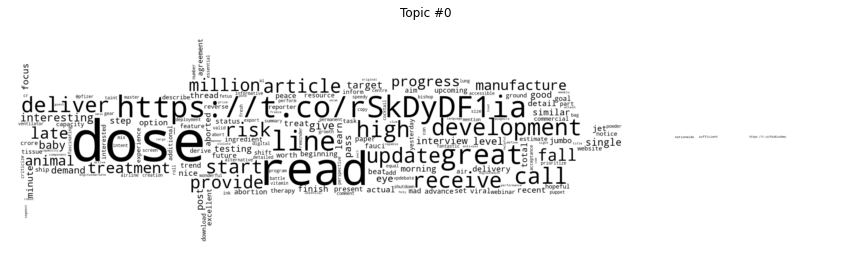

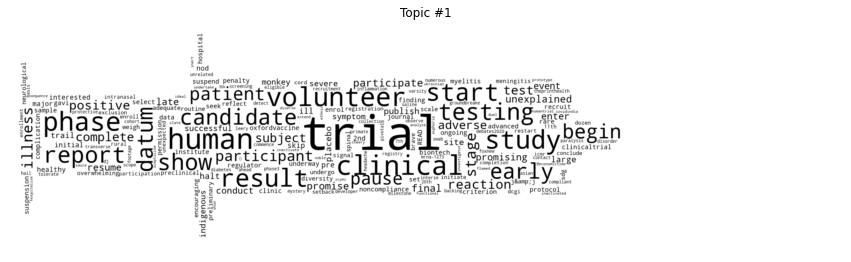

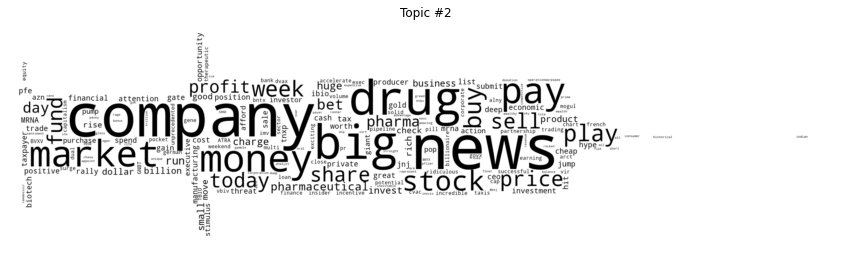

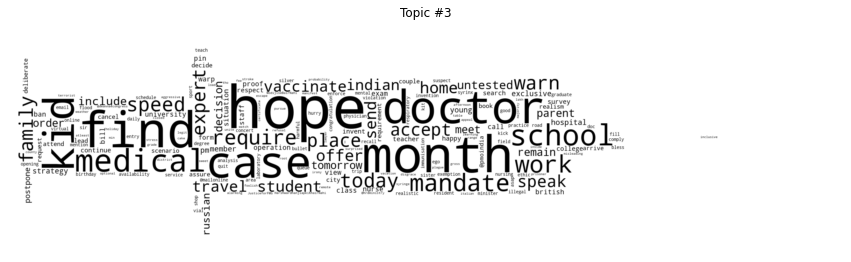

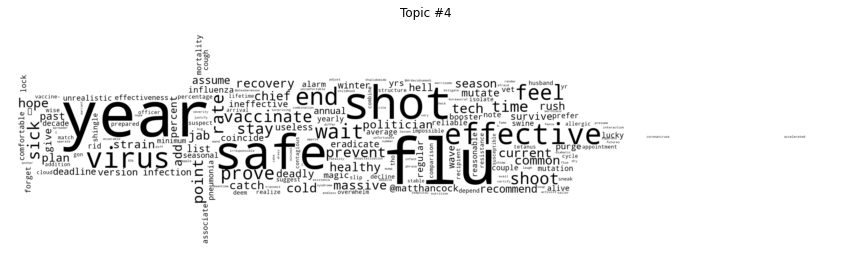

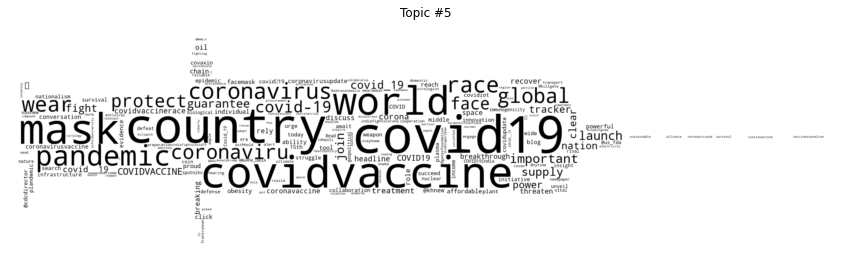

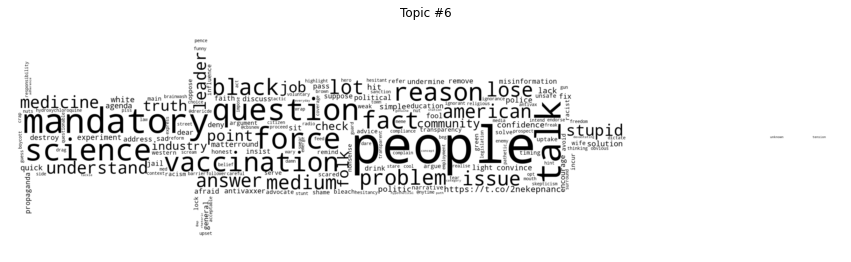

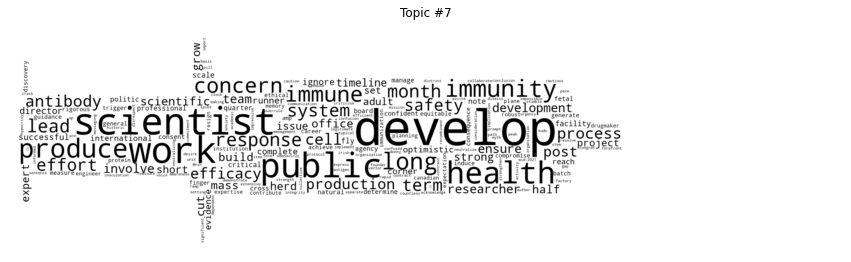

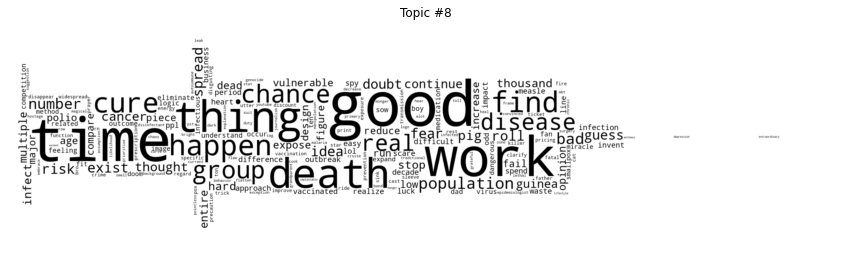

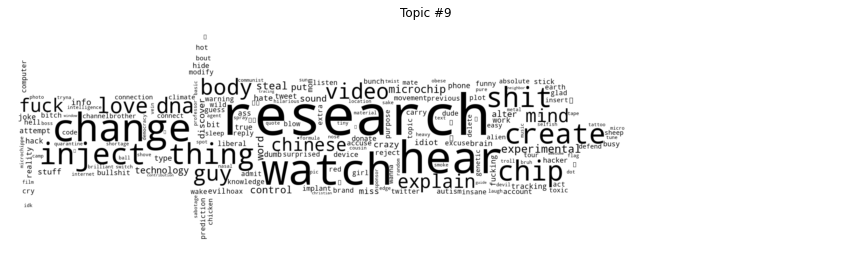

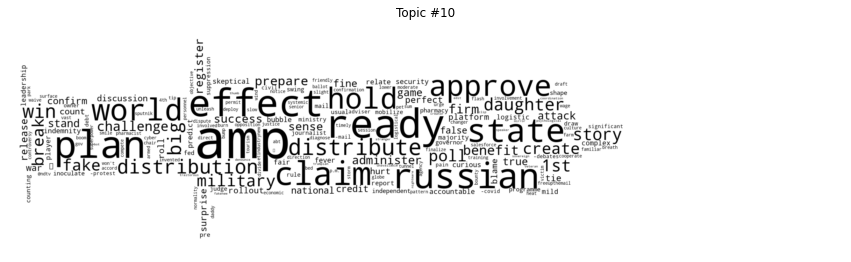

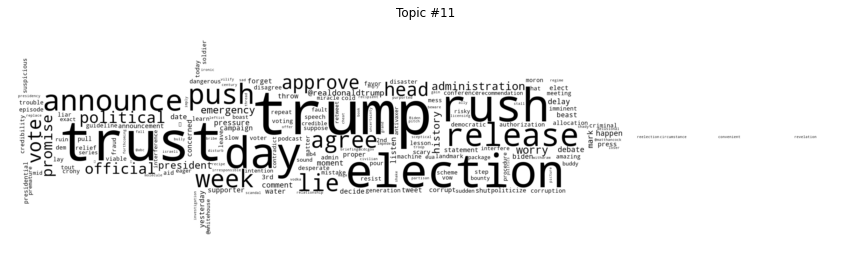

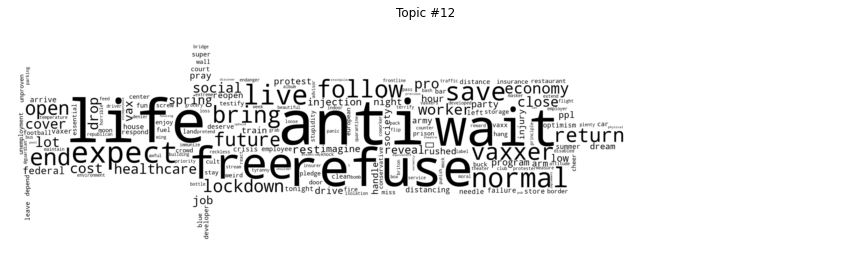

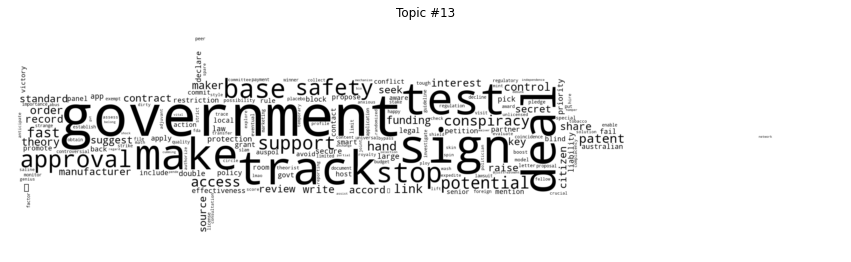

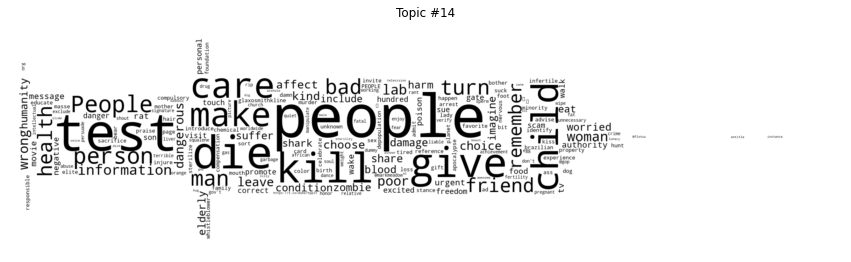

In [60]:
max_words = 200
syringe_mask = np.array(Image.open('Syringe-Silhouette.jpg'))
wordcloud = WordCloud(background_color='#fff', color_func=lambda *args, **kwargs: (0,0,0),
                      mask=syringe_mask)

for t in np.arange(model.num_topics):               
    plt.figure(figsize=(15, 15))
    wordcloud.generate_from_frequencies(frequencies=dict(model.show_topic(t, max_words)))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()